In [48]:
file_path : str = "../testdata/test2_output/shading_corrected.zarr/"
output_dir = "../testdata/test2_output"
metadata_path = "../testdata/test1_output/test1_metadata.yaml"

output_csv_name = "stitch_positions.csv"
output_image_name = "stitched.zarr"

every_t_stitch = 0
target_channel = '10x_Fukai_DIA_IS'
max_ind = 48
num_cpus = 10

In [49]:
from pathlib import Path
file_path = Path(file_path)
assert file_path.exists()
output_csv_path = Path(output_dir) / output_csv_name
output_image_path = Path(output_dir) / output_image_name
metadata_path = Path(metadata_path)


In [7]:
import ray
ray.init(num_cpus=num_cpus)

/home/fukai/.pyenv/versions/miniforge3-latest/envs/microflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-19 16:48:33,960	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-19 16:48:37,747	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.13
Ray version:,2.9.0
Dashboard:,http://127.0.0.1:8266


# Import packages and define functions

In [47]:
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx
from m2stitch import stitch_images
import zarr
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
from dask import array as da
import yaml
from utils import merge_mosaic_images, show_ray_progress

In [18]:
def _calc_overlap_area_ratio(image_shape,relative_pos):
    """Calculate the image overlap area ratio with respect to the image area.
    
    """
    percentage = 1.
    for s, p in zip(image_shape,relative_pos):
        percentage *= np.clip(1-np.abs(p/s),0,None)
    return percentage


def parse_positions_to_pairs(
    image_shape,
    tile_indices = None, 
    estimated_positions = None,
    overlap_threshold_percentage : float = 5,
    ):
    """Parse image positions to image pairs.

    Parameters
    ----------
    image_shape : List[Int]
        The shape of a single input image.
    tile_indices : Optional[IntArray], optional
        The integer index of the tiles. If None, `estimated_positions` must be supplied.
    estimated_positions : Optional[NumArray], optional
        The estimated position of the tiles in pixel. If None, `tile_indices` must be supplied.
    overlap_threshold_percentage : float, optional
        The area percentage threshold to calculate pair displacement between tiles. Effective only when tile_indices is None.
    """

    image_pairs = []
    if tile_indices is not None:
        for (j1,ind1), (j2,ind2) in combinations(enumerate(tile_indices),2):
            # if the images are the next to each other or at the same position
            diff = np.abs(ind1 - ind2)
            if ((np.max(diff) == 1 and np.sum(diff == 1) == 1)) or np.all(ind1 == ind2): 
                if estimated_positions is not None:
                    dpos = estimated_positions[j2]-estimated_positions[j1]
                else:
                    dpos = None
                image_pairs.append({
                    "image_index1":j1,
                    "image_index2":j2,
                    "index_displacement":ind2-ind1,
                    "estimated_displacement":dpos,
                }) # image 2 position with respect to image 1
    else:
        for (j1,pos1), (j2,pos2) in combinations(enumerate(estimated_positions),2):
            if _calc_overlap_area_ratio(image_shape,np.array(pos2)-np.array(pos1)) > overlap_threshold_percentage/100:
                image_pairs.append({
                    "image_index1":j1,
                    "image_index2":j2,
                    "index_displacement":None,
                    "estimated_displacement":pos2-pos1
                })
    
    if len(image_pairs) == 0:
        raise RuntimeError("There is no valid image pairs. Please check tile_indices and estimated_positions.")

    pairs_df = pd.DataFrame.from_records(image_pairs)
    pairs_graph = nx.Graph()
    nodes_count = len(estimated_positions if estimated_positions is not None else tile_indices) 
    pairs_graph.add_nodes_from(range(nodes_count))
    pairs_graph.add_edges_from(pairs_df[["image_index1","image_index2"]].values)

    if len(list(nx.connected_components(pairs_graph))) > 1:
        raise ValueError("Parsing positions resulted more than one connected graphs.")

    return pairs_df

In [22]:
images = zarr.open(str(file_path))
metadata = yaml.safe_load(metadata_path.read_text())

In [30]:
channel_names = metadata["channel_names"]
print(channel_names)
target_channel_index = channel_names.index(target_channel)

mosaic_positions = metadata["mosaic_positions"]
display(mosaic_positions[:10])

mosaic_positions = np.array(mosaic_positions)
ok_inds=np.linalg.norm(mosaic_positions[1:]-mosaic_positions[:-1],axis=1) < np.max(images.shape[-2:])*1.5 # assume stage moves less than 1.5x of the image size
ok_inds = [True] + list(ok_inds)
ok_inds = np.array(ok_inds) & (np.arange(mosaic_positions.shape[0])<max_ind)
mosaic_positions = mosaic_positions[ok_inds,:]

['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS']


[[-9256.679704924027, -2723.983470101535],
 [-9396.41955773792, -200.85014553552105],
 [-9536.159410551814, 2322.283179030493],
 [-9675.899263365709, 4845.416503596507],
 [-7633.982482156359, 7489.377520445213],
 [-7494.242629342464, 4966.244195879199],
 [-7354.502776528569, 2443.110871313185],
 [-7214.762923714674, -80.02245325282935],
 [-7075.023070900778, -2603.1557778188435],
 [-4893.366436877533, -2482.3280855361522]]

In [31]:
mosaic_positions = np.array(mosaic_positions)
pairs =  parse_positions_to_pairs(
    images.shape[-2:],
    estimated_positions = mosaic_positions,
    overlap_threshold_percentage  = 2,
)

index_positions = [None for _ in range(len(mosaic_positions))]
index_positions[0] = np.array([0,0])

# Change absolute positions to index difference (removed after migrating to microtailor)
for i in range(10):
    for i, row in pairs.iterrows():
        for sign, (i1, i2) in zip([1,-1],[(row.image_index1,row.image_index2),(row.image_index2,row.image_index1)]):
            if index_positions[i1] is not None:
                disp = row.estimated_displacement
                index_displacement = (np.abs(disp) > np.min(images.shape[-2:])*0.5).astype(int) * np.sign(disp) * sign
                calc_pos = index_positions[i1] + index_displacement

                if index_positions[i2] is None:
                    index_positions[i2] = calc_pos
                else:
                    assert np.all(index_positions[i2] == calc_pos)
assert not np.any([p is None for p in index_positions])
index_positions = np.array(index_positions)
index_positions -= np.min(index_positions,axis=0)
index_positions = index_positions.astype(int)
print(index_positions[:10])

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 4]
 [1 3]
 [1 2]
 [1 1]
 [1 0]
 [2 0]]


In [32]:
target_Ts = [0] if every_t_stitch == 0 else list(range(0, images.shape[2], every_t_stitch))

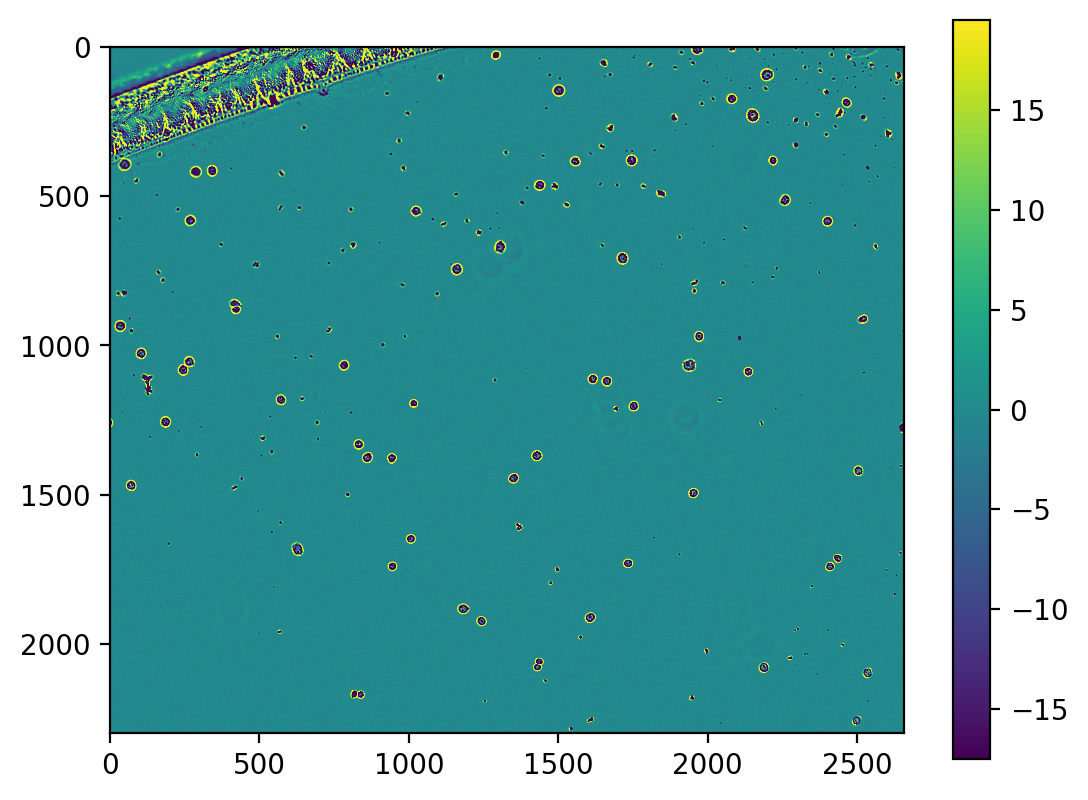

In [33]:
qs = np.percentile(
    np.concatenate([
        np.ravel(images[target_T,target_channel_index]) 
        for target_T in target_Ts]),q=[1,99])
plt.imshow(images[0,0,0,0],vmax=qs[1],vmin=qs[0])
plt.colorbar()

In [ ]:
@ray.remote
def stitch_T(T):
    target_images = np.array([images[ind,T,target_channel_index] for ind in np.nonzero(ok_inds)[0]])
    assert target_images.shape[1] == 1
    target_images = target_images[:,0]
    positions, _ = stitch_images(
        target_images,
        position_indices = index_positions,
        position_initial_guess = mosaic_positions,
        row_col_transpose=False
    )
    positions.assign(T=T)
    return positions

In [41]:
T = target_Ts[0]
positions = ray.get([stitch_T.remote(T)])[0]
target_images = np.array([images[ind,T,target_channel_index] for ind in np.nonzero(ok_inds)[0]])


100%|██████████| 48/48 [00:00<00:00, 103.84it/s]


ValueError: could not broadcast input array from shape (2296,2656) into shape (1,2296)

In [42]:
target_images.shape

(48, 1, 2296, 2656)

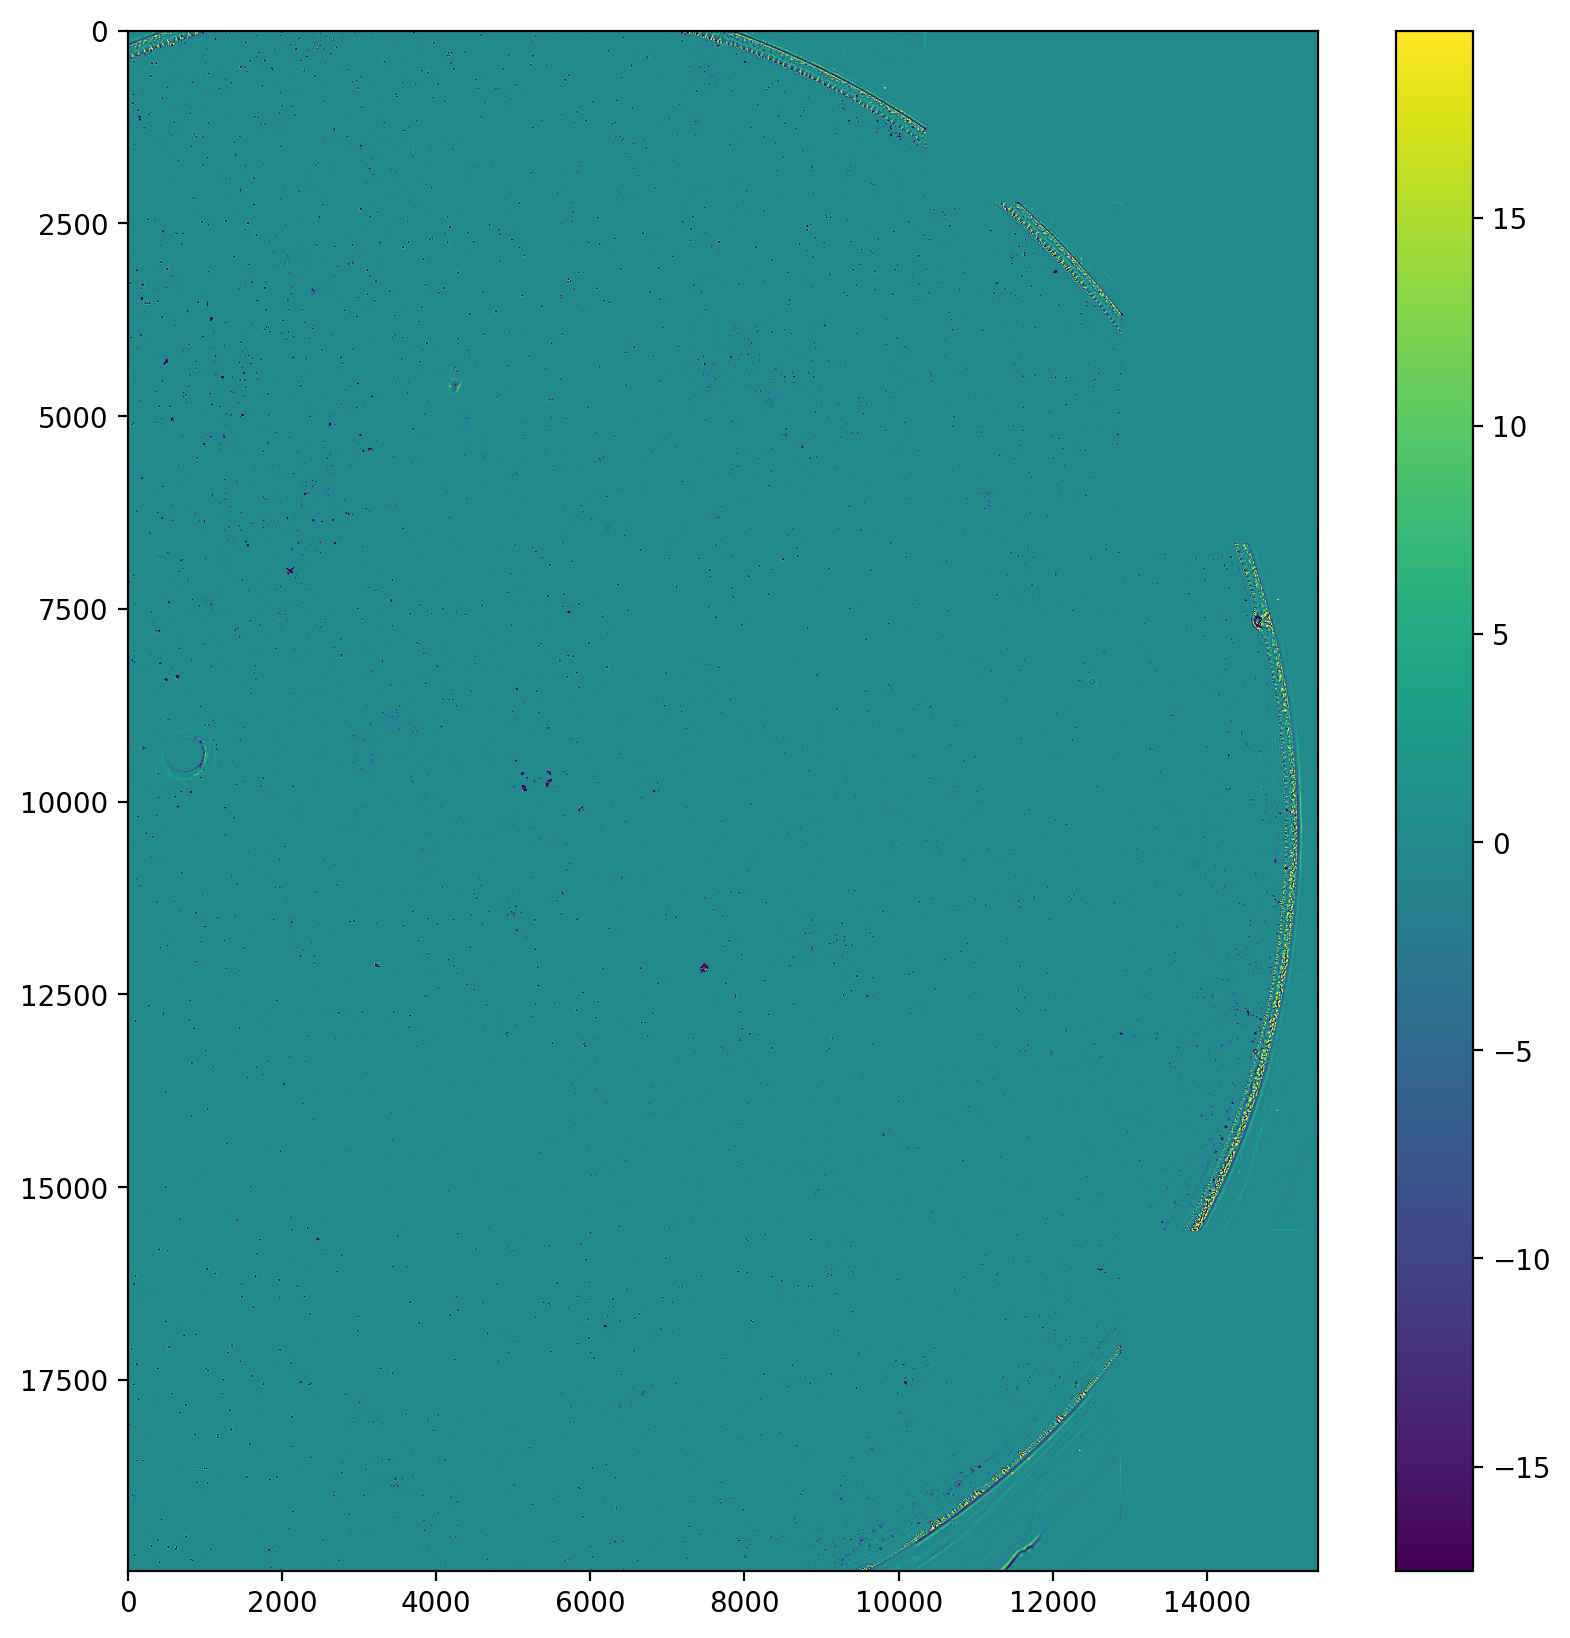

In [45]:
stitched = merge_mosaic_images(target_images[:,0], positions[["y_pos","x_pos"]].values)
plt.figure(figsize=(10,10))
#plt.imshow(stitched[:3000,:3000],vmin=qs[0],vmax=qs[1])
plt.imshow(stitched[:,:],vmin=qs[0],vmax=qs[1])
plt.colorbar()

In [50]:
all_positions = show_ray_progress([stitch_T.remote(T) for T in target_Ts])

100%|██████████| 1/1 [04:56<00:00, 296.60s/it]


In [51]:
all_positions_df=pd.concat(all_positions)
all_positions_df.to_csv(output_csv_path,index=False)

# Final stitch images 

In [52]:
final_positions = all_positions_df.groupby(["row","col"]).median()
final_positions = final_positions.loc[[tuple(x) for x in index_positions]]
final_positions

100%|██████████| 48/48 [00:00<00:00, 103.12it/s]


y_pos    x_pos
row col                  
0   0        0.0     26.0
    1        2.0   2580.0
    2        5.0   5134.0
    3        7.0   7689.0
1   4     2221.0  10236.0
    3     2218.0   7682.0
    2     2214.0   5128.0
    1     2212.0   2574.0
    0     2208.0     21.0
2   0     4416.0     18.0
    1     4419.0   2571.0
    2     4424.0   5125.0
    3     4426.0   7679.0
    4     4429.0  10233.0
3   5     6640.0  12786.0
    4     6638.0  10231.0
    3     6634.0   7676.0
    2     6632.0   5121.0
    1     6629.0   2567.0
    0     6625.0     15.0
4   0     8833.0     12.0
    1     8837.0   2565.0
    2     8841.0   5118.0
    3     8843.0   7671.0
    4     8846.0  10228.0
    5     8849.0  12783.0
5   5    11058.0  12780.0
    4    11055.0  10225.0
    3    11052.0   7670.0
    2    11049.0   5116.0
    1    11046.0   2563.0
    0    11040.0      8.0
6   0    13248.0      6.0
    1    13252.0   2559.0
    2    13257.0   5114.0
    3    13261.0   7667.0
    4    13262.0  10224.0
    5    13266.0  12777.0
7   4    15469.0  10218.0
    3    15466.0   7663.0
    2    15464.0   5111.0
    1    15460.0   2555.0
    0    15457.0      3.0
8   0    17666.0      0.0
    1    17668.0   2553.0
    2    17671.0   5108.0
    3    17674.0   7661.0
    4    17677.0  10215.0

In [53]:
mosaic_positions = final_positions[["y_pos","x_pos"]].values
final_mosaic_positions = (mosaic_positions - np.min(mosaic_positions, axis=0)[np.newaxis]).round().astype(int)
mosaic_size = (np.max(mosaic_positions, axis=0) + np.array(images.shape[-2:])).astype(int)

In [54]:
from tqdm import tqdm
from numcodecs import Zstd
synchronizer = zarr.ProcessSynchronizer(str(output_image_path).replace(".zarr",'.lock.sync'))
#with zarr.ZipStore(output_image_path, mode='w') as store:
shape = list(images.shape[1:-2])+list(mosaic_size)
chunks = [1] * len(images.shape[1:-2]) + [2048, 2048]

output_zarr = zarr.open(str(output_image_path),
                        shape=shape,
                        chunks=chunks,
                        dimension_separator="/",                        
                        compressor=Zstd(),
                        dtype=images.dtype,
                        synchronizer=synchronizer,
                        mode="w")

@ray.remote
def process_chunk(ind):
    for M, position in enumerate(final_mosaic_positions):
        new_ind = list(ind) + [slice(position[0],position[0] + images.shape[-2]),
                               slice(position[1],position[1] + images.shape[-1])]
        im = images[tuple([M]+list(ind))]
        output_zarr[tuple(new_ind)] = im

inds = np.ndindex(images.shape[1:-2])
res = [process_chunk.remote(ind) for ind in tqdm(inds)]

8it [00:00, 2210.29it/s]


In [55]:
show_ray_progress(res)

100%|██████████| 8/8 [00:57<00:00,  7.19s/it]


[None, None, None, None, None, None, None, None]

In [56]:
stitched = zarr.open(str(output_image_path))

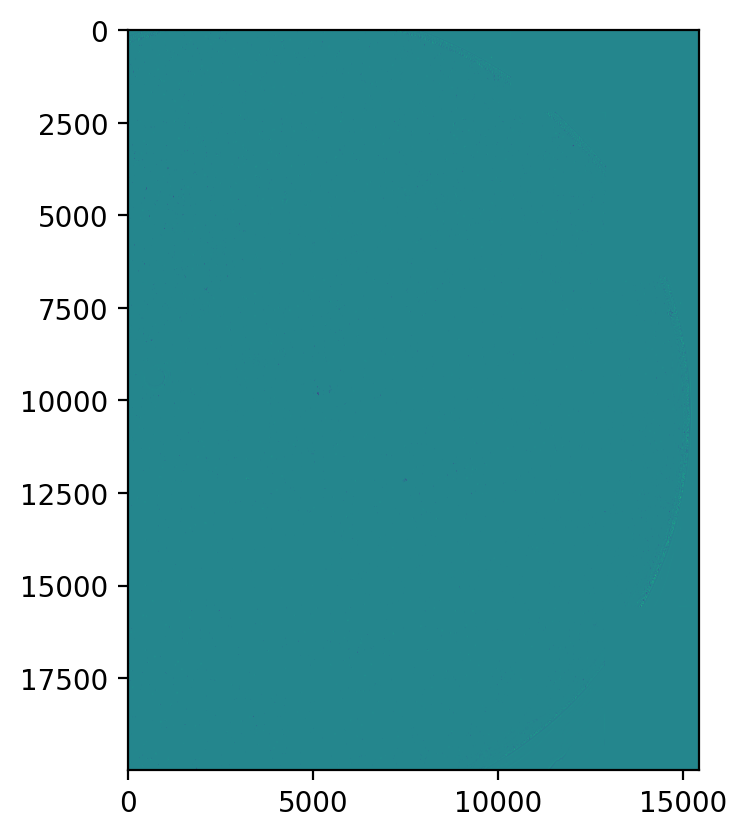

In [57]:
plt.imshow(stitched[0,0,0])